## **Netflix Movie Clustering**

In this notebook we try to cluster netflix shows into various categories based on their description. We use K means clustering along with various text encoding techniques to find the the optimum number of separable clusters. 
The main metric used to evaluate a cluster is silhoutte score.

The following steps have been performed



1.   Importing Libraries
2.   Loading the Dataset
3.   Data cleaning and subsetting
4.   Data Visualizations 
5.   Text Preprocessing
6.   Implementing K means clustering using TF-IDF vectorization
7.   Tuning K Value 
8.   Validating results
9.   Implementing K means clustering using Doc2Vec word embedding
10.  Tuning K value
11.  Validaing results
12.  Implementing K means clustering using Auto Encoder word embedding
13.  Tuning K value
14.  Validaing results




### **Importing Libraries **

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import itertools as it
from collections import Counter
import pickle
import sys
from google.colab import files


# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering 
import scipy.cluster.hierarchy as shc


### **Loading Dataset**

In [ ]:
netflix_titles = pd.read_csv("netflix_titles.csv")
print("Shape of the dataset: ",netflix_titles.shape)
netflix_titles.head()

Shape of the dataset:  (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### **Data Cleaning and Subsetting**

In [ ]:
print("Checking for duplicates \n")
print("Number of unique titles:",netflix_titles['title'].nunique())
print("Number of unique show Id:",netflix_titles['show_id'].nunique())
print("\n")

print("Checking for Nulls \n")
print(netflix_titles.isnull().sum())

#netflix_titles = netflix_titles[['show_id','title','description']]

Checking for duplicates 

Number of unique titles: 8807
Number of unique show Id: 8807


Checking for Nulls 

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


### **Data Visualization**

Text(0, 0.5, 'Ratio')

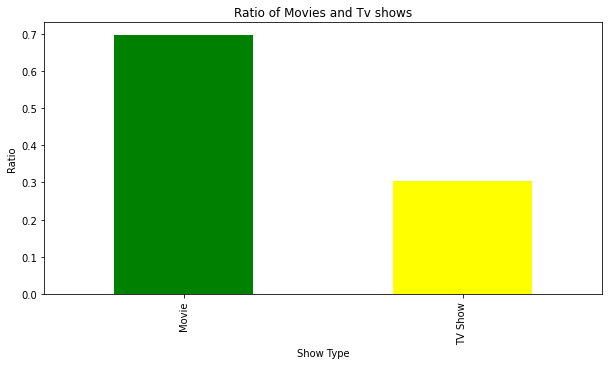

In [ ]:
movie_perc = netflix_titles['type'].value_counts()/netflix_titles.shape[0]
plot1 = movie_perc.plot.bar(color = ['green','yellow'],figsize = (10,5))
plt.title("Ratio of Movies and Tv shows")
plt.xlabel("Show Type")
plt.ylabel("Ratio")


Text(0, 0.5, 'Number of shows')

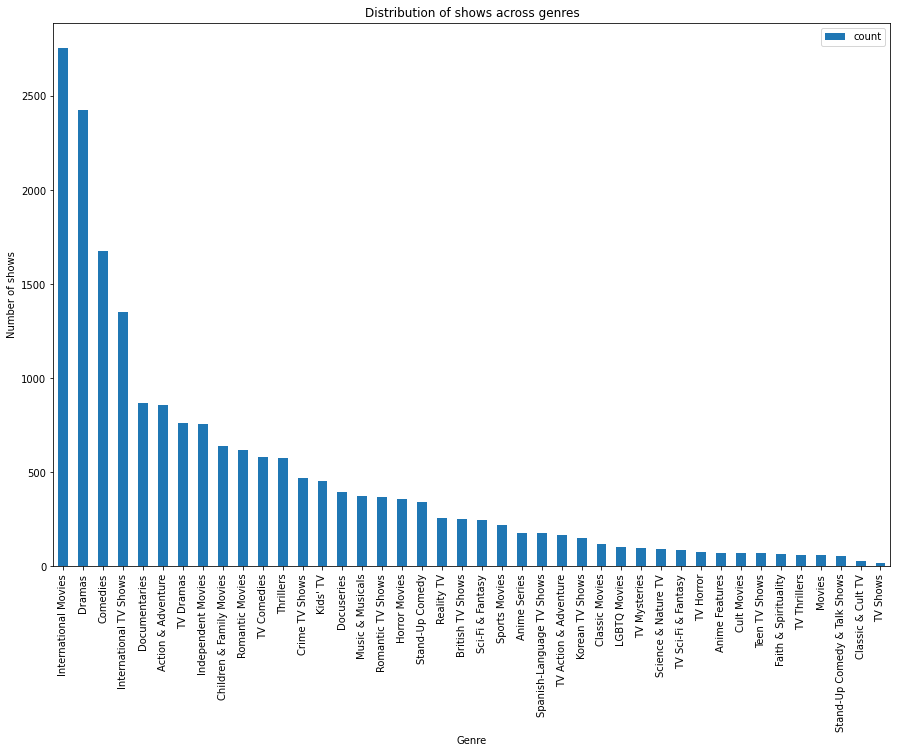

In [ ]:
genres = netflix_titles['listed_in']
genres = [x.split(', ') for x in genres]
genres_count = Counter(it.chain(*map(set, genres)))
genres_df = pd.DataFrame.from_dict(genres_count,orient='index').reset_index()
genres_df.columns = ['genres','count']
genres_df.sort_values(['count'],inplace = True,ascending = False)
genres_df.plot.bar(x = 'genres',y='count',figsize =(15,10) )
plt.title("Distribution of shows across genres")
plt.xlabel("Genre")
plt.ylabel("Number of shows")


### **Text Preprocessing**

### Glove Encodings

In [ ]:
### Pre Trained Sentence Bert Embeddings for the Dataset
with open('glove_embeddings.pkl', 'rb') as fp:
    glove_encodings = pickle.load(fp)
fp.close()

### SentenceBert Encodings

In [ ]:
### Pre Trained Sentence Bert Embeddings for the Dataset
with open('sentBert_embeddings_3.pkl', 'rb') as fp:
    sentBert_encodings = pickle.load(fp)
fp.close()

### t-SNE Visualization of all 3 encodings

In [ ]:
from sklearn.preprocessing import MinMaxScaler

MM_X = MinMaxScaler()

glove_X = MM_X.fit_transform(glove_encodings)
bert_X = MM_X.fit_transform(sentBert_encodings)

In [ ]:
tsne = TSNE(n_components=2)
print("t-SNE of glove encodings")
tsne_mat_glove = tsne.fit_transform(glove_encodings)
print("t-SNE of sentenceBert ecodings")
tsne_mat_bert = tsne.fit_transform(sentBert_encodings)

t-SNE of glove encodings


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE of sentenceBert ecodings


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


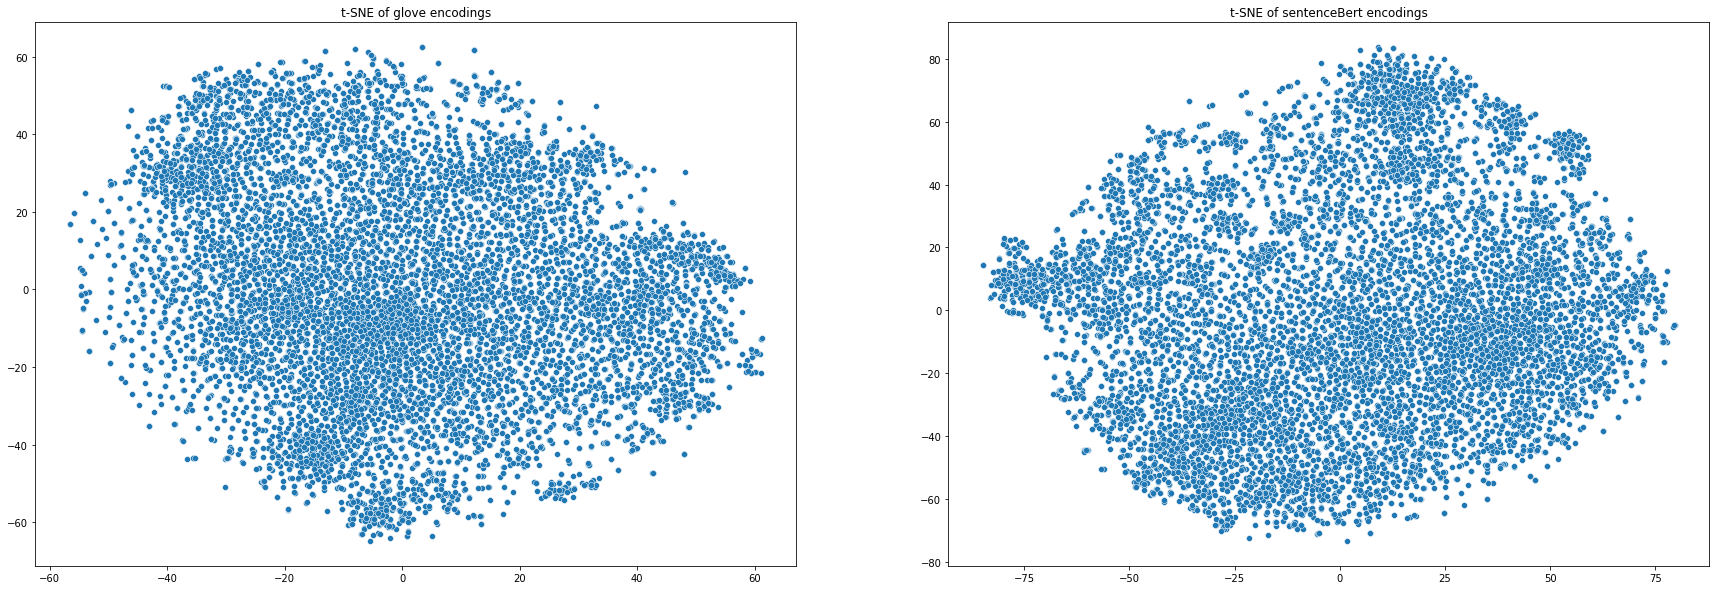

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30,10))
sns.scatterplot(x = tsne_mat_glove[:,0],y = tsne_mat_glove[:,1],ax = axes[0]).set(title='t-SNE of glove encodings')
sns.scatterplot(x = tsne_mat_bert[:,0],y = tsne_mat_bert[:,1],ax = axes[1]).set(title='t-SNE of sentenceBert encodings')
plt.show()

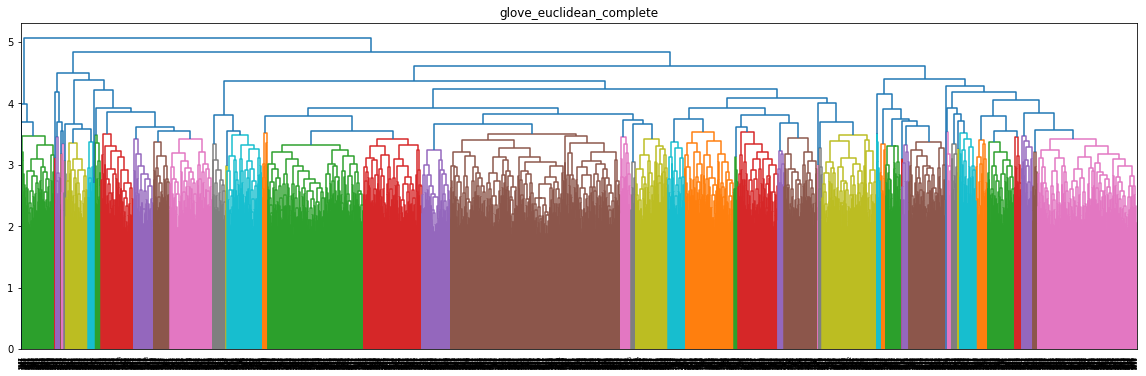

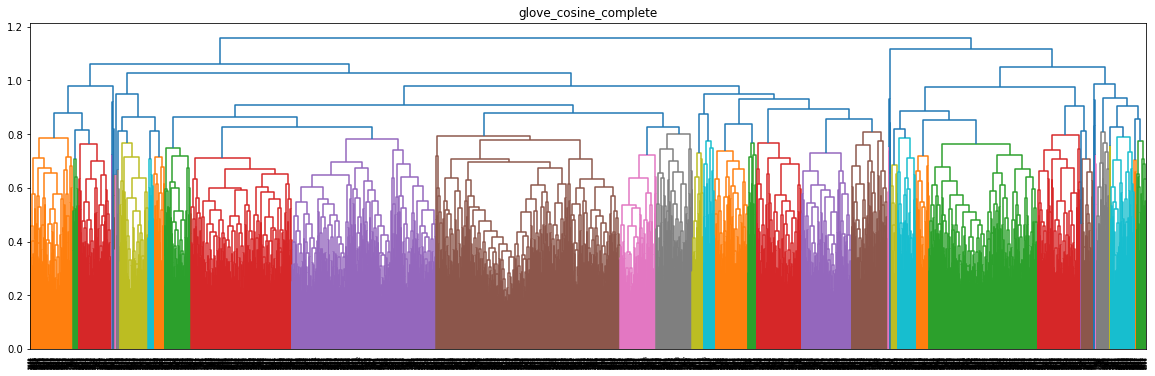

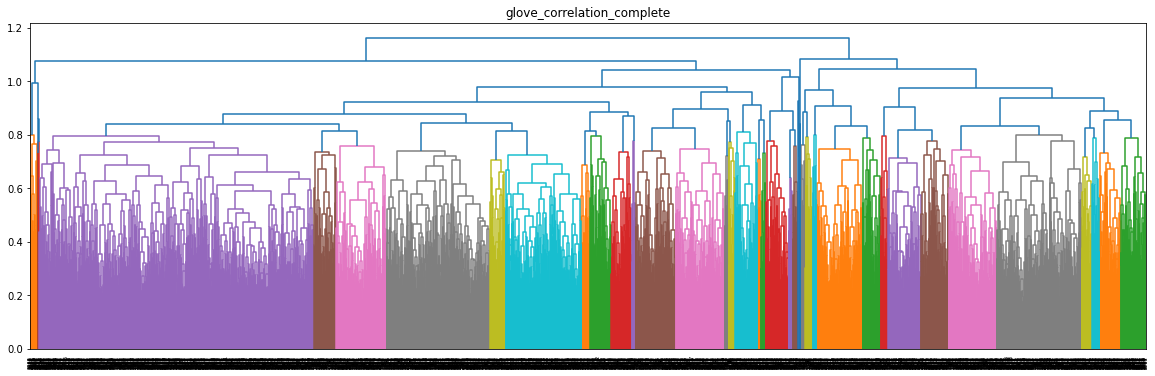

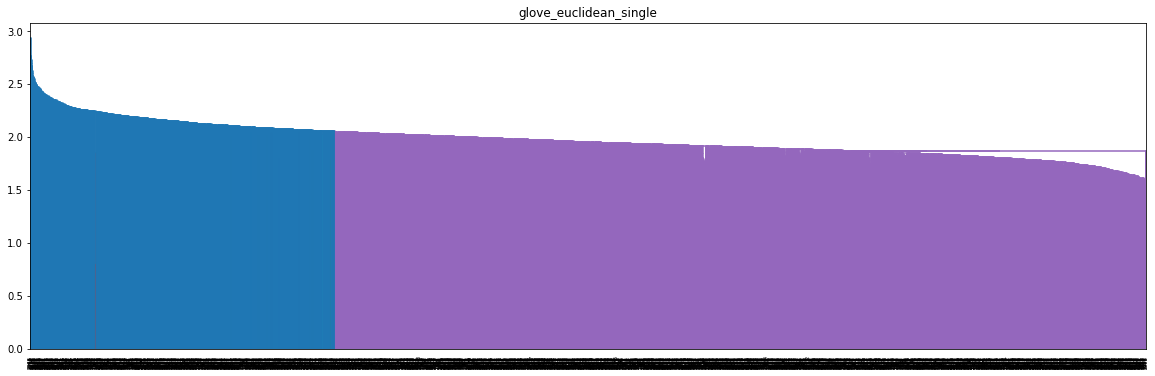

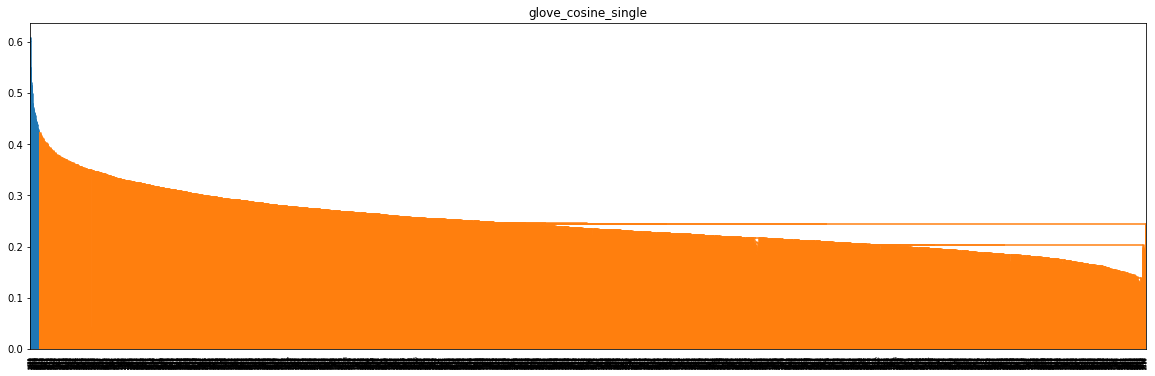

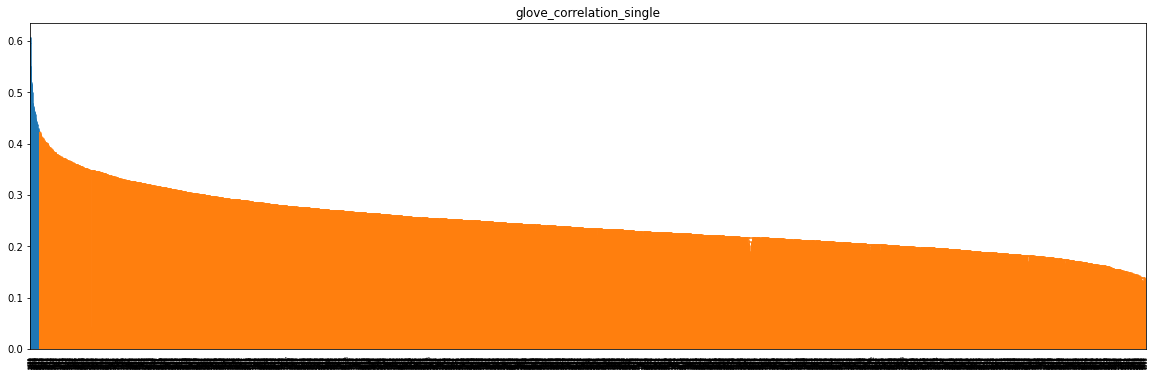

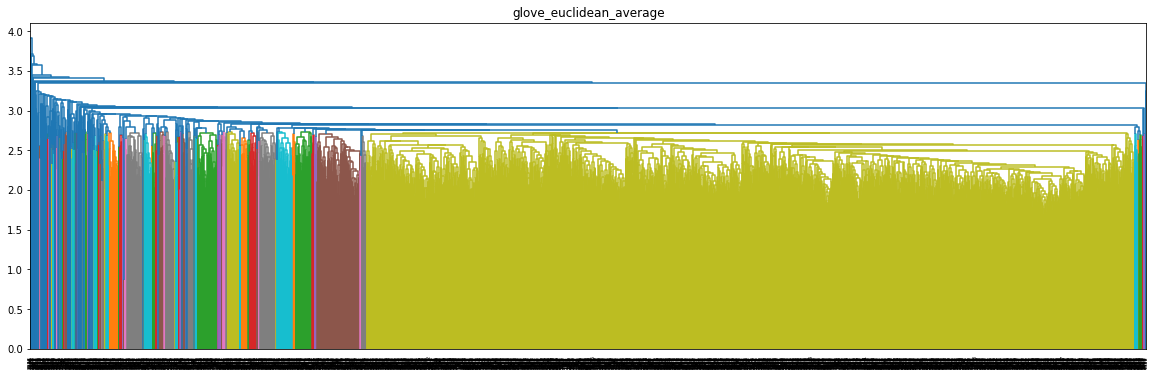

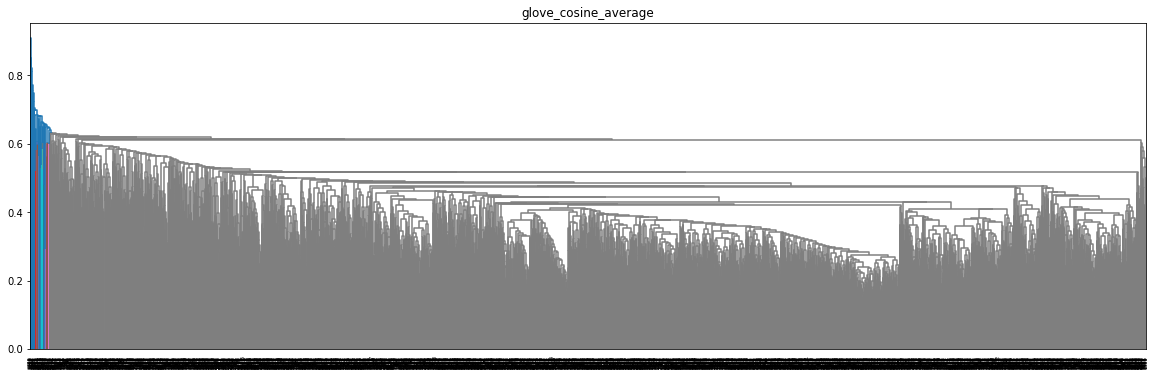

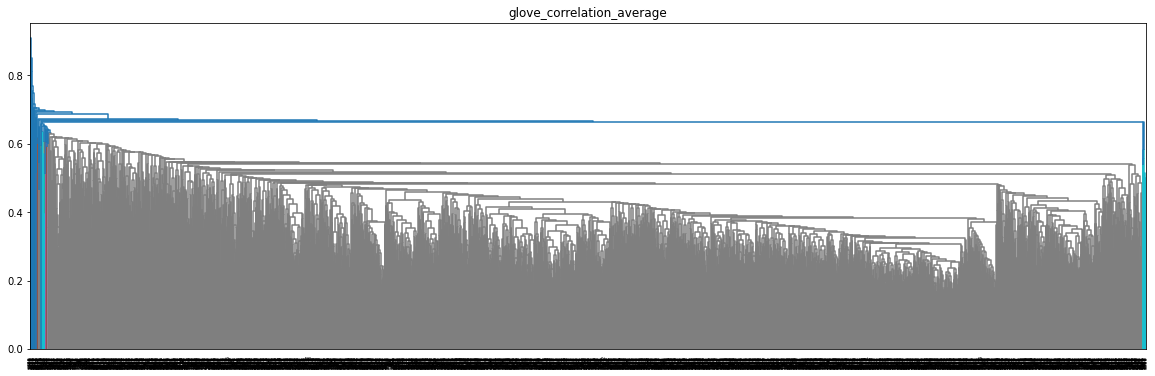

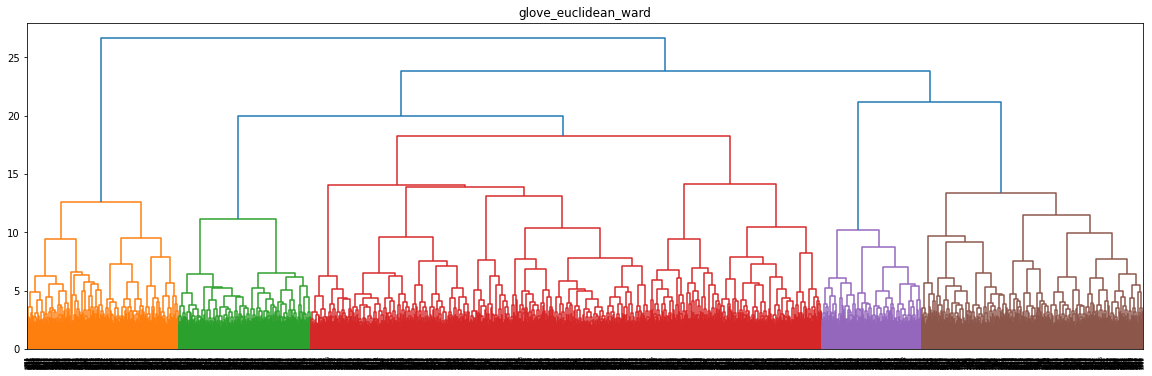




Fail:  glove_cosine_ward
Fail:  glove_correlation_ward


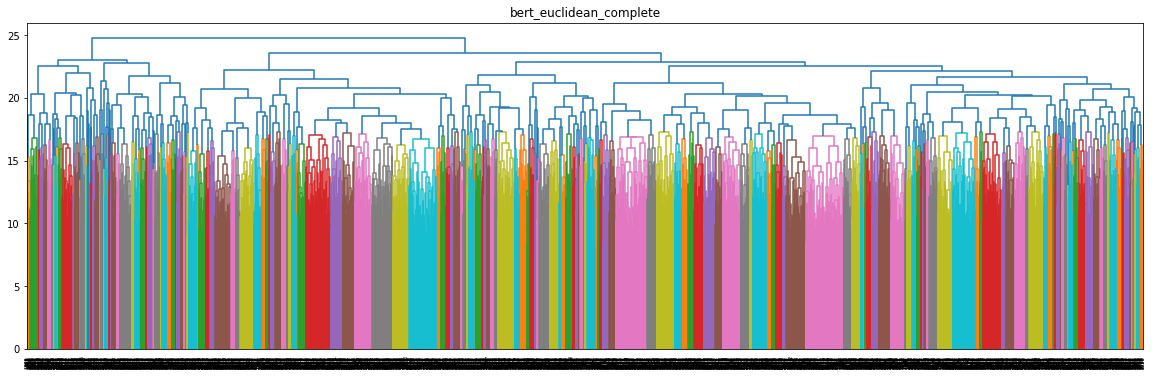

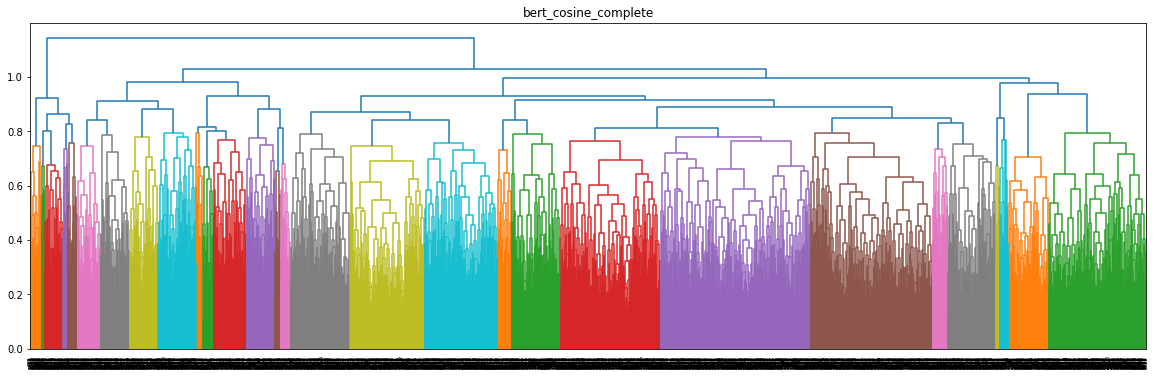

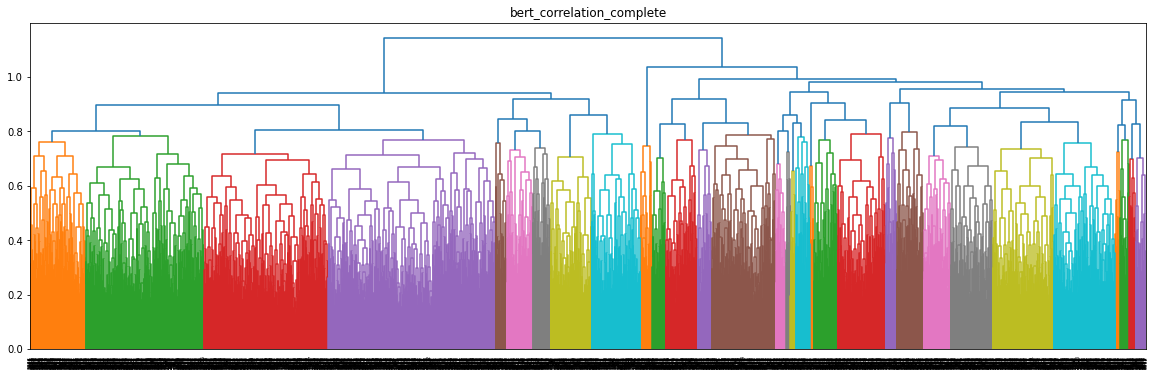

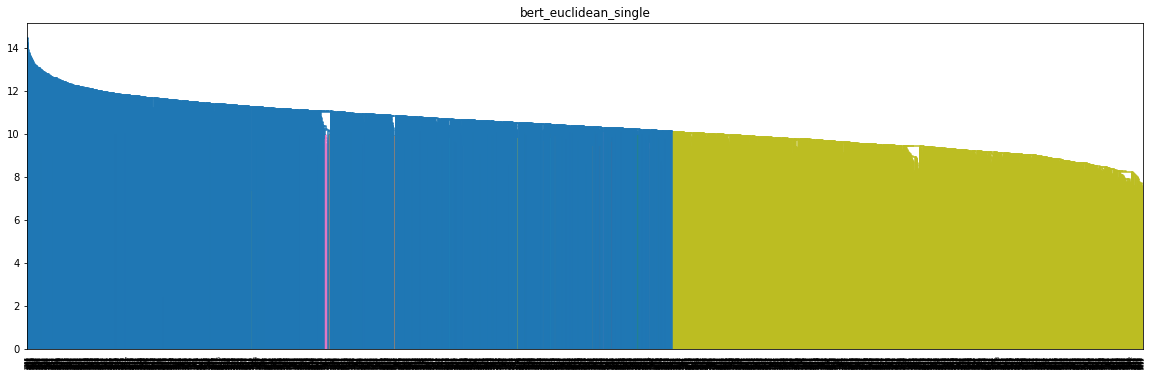

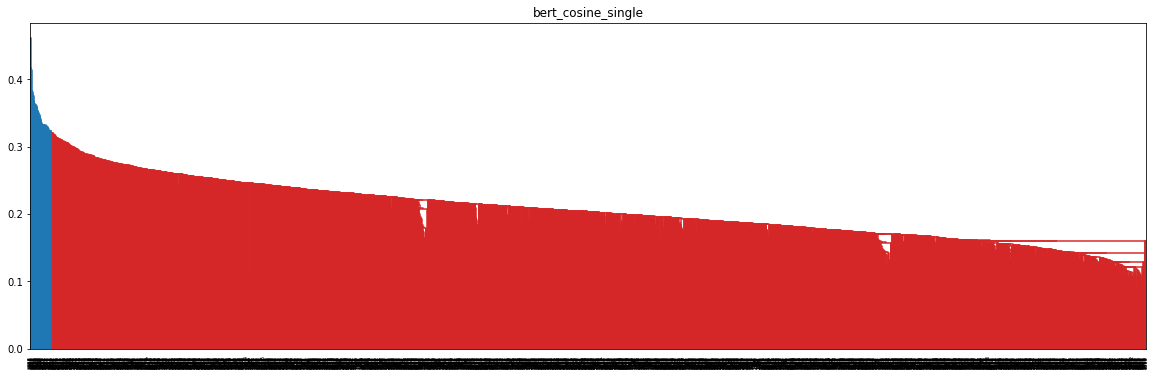

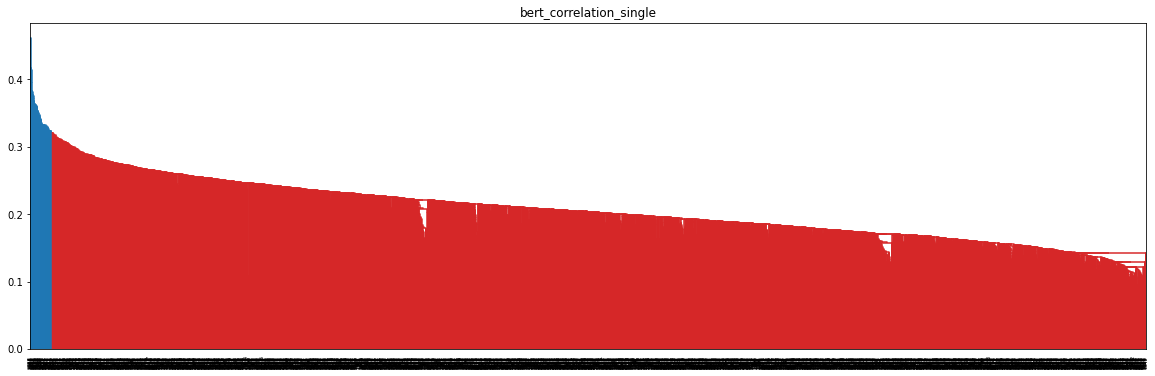

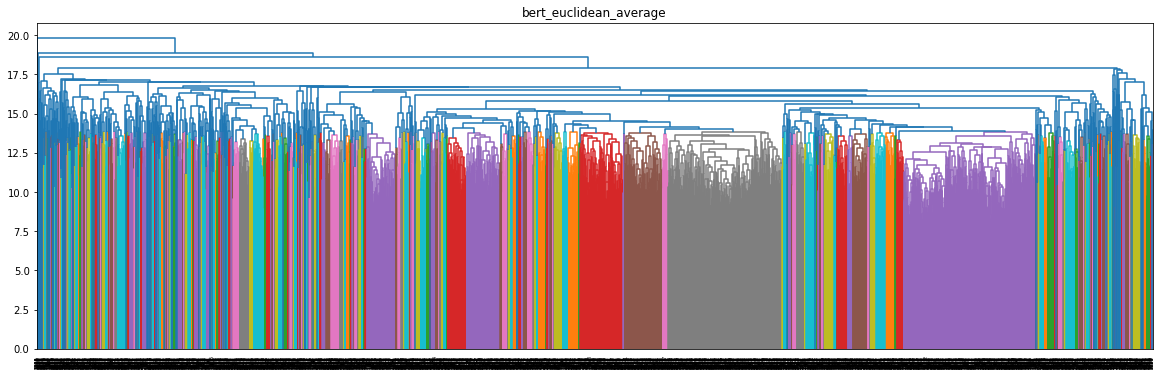

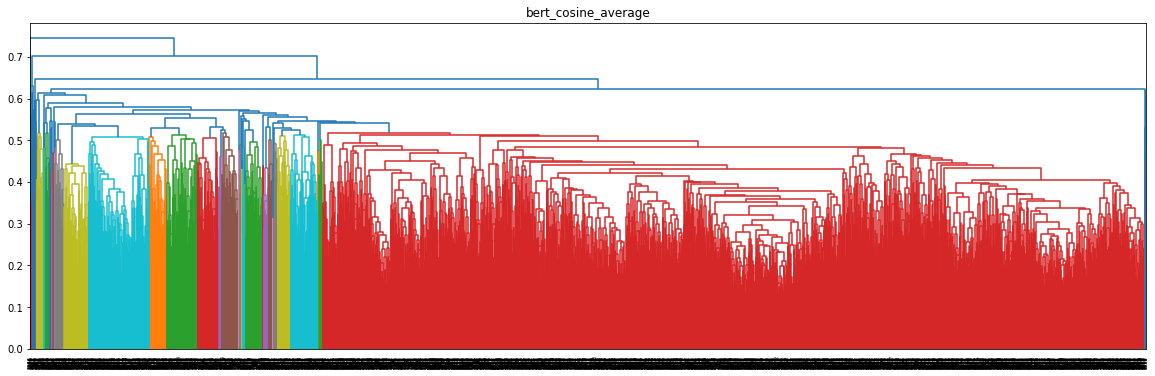

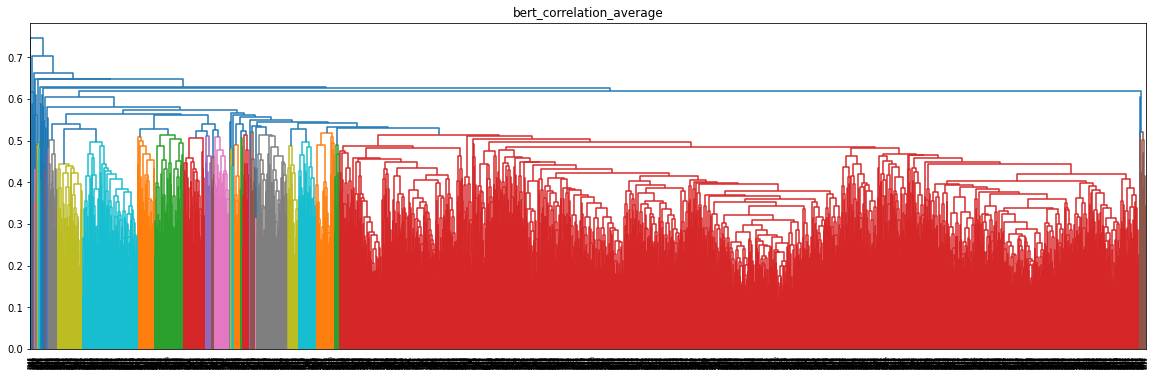

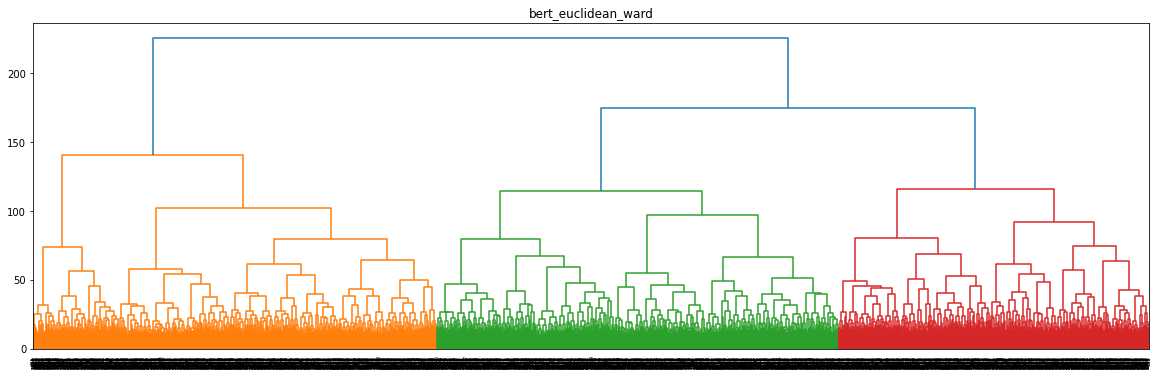




Fail:  bert_cosine_ward
Fail:  bert_correlation_ward


In [ ]:

sys.setrecursionlimit(10000)
embeddings = [glove_encodings, sentBert_encodings]
embedding_names = ['glove','bert']
methods = ['complete','single','average','ward']
metrics = ['euclidean','cosine','correlation']
for encoding,enc_name in zip(embeddings,embedding_names):
  for method in methods:
    for metric in metrics:
      plot_title = enc_name+"_"+metric+"_"+method
      try:
        clusters = shc.linkage(encoding[:4000], 
                    method=method, 
                    metric=metric)
        plt.figure(figsize=(20, 6))
        plt.title(plot_title)
        shc.dendrogram(Z=clusters)
        #plt.savefig(plot_title+'.png')
        #files.download(plot_title+'.png')
        plt.show()
        
        print('\n\n')
      except:
        print("Fail: ", plot_title )  

In [ ]:
embeddings = [glove_encodings,sentBert_encodings]
x_names = ['glove','bert']
for X,X_name in zip(embeddings,x_names):
  if X_name == 'glove':
    thresholds = [10,15,25]
  else:
    thresholds = [50,100,130]
  for dt in thresholds:
    print("\n")
    print("dt: ",dt)
    print("enc: ",X_name)
    model = AgglomerativeClustering(distance_threshold = dt,n_clusters= None, affinity="euclidean",linkage = 'ward')
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    ch_score = calinski_harabasz_score(X, cluster_labels)
    db_score = davies_bouldin_score(X, cluster_labels)
    print("Silhoutte: ",silhouette_avg)
    print("Calinski Harabasz Score: ", ch_score)
    print("Davies Bouldin Score: ",db_score )
    print("Number of clusters: ", len(set(cluster_labels)))



dt:  10
enc:  glove
Silhoutte:  -0.0046130205
Calinski Harabasz Score:  47.23210136203393
Davies Bouldin Score:  4.747158244045513
Number of clusters:  39


dt:  15
enc:  glove
Silhoutte:  -0.001279112
Calinski Harabasz Score:  82.17249717995682
Davies Bouldin Score:  5.118470576048446
Number of clusters:  16


dt:  25
enc:  glove
Silhoutte:  0.011118344
Calinski Harabasz Score:  153.6047288284948
Davies Bouldin Score:  5.3547092448449325
Number of clusters:  5


dt:  50
enc:  bert
Silhoutte:  -0.0027209807
Calinski Harabasz Score:  46.05531575244759
Davies Bouldin Score:  3.8251360553658222
Number of clusters:  70


dt:  100
enc:  bert
Silhoutte:  0.0026507191
Calinski Harabasz Score:  126.60928115697052
Davies Bouldin Score:  4.456107823018547
Number of clusters:  14


dt:  130
enc:  bert
Silhoutte:  0.0041383537
Calinski Harabasz Score:  182.0134438610548
Davies Bouldin Score:  4.667036218004617
Number of clusters:  8


In [ ]:
X = sentBert_encodings
model = AgglomerativeClustering(distance_threshold = 100,n_clusters= None, affinity="euclidean",linkage = 'ward')
cluster_labels = model.fit_predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)
ch_score = calinski_harabasz_score(X, cluster_labels)
db_score = davies_bouldin_score(X, cluster_labels)
print("Silhoutte: ",silhouette_avg)
print("Calinski Harabasz Score: ", ch_score)
print("Davies Bouldin Score: ",db_score )
print("Number of clusters: ", len(set(cluster_labels)))


Silhoutte:  0.0026507191
Calinski Harabasz Score:  126.60928115697052
Davies Bouldin Score:  4.456107823018547


1     1288
7     1042
13     976
0      909
2      760
6      580
3      569
10     506
8      470
5      419
9      415
4      388
11     365
12     120
dtype: int64

14

In [ ]:
#Checking Cluster distribution
netflix_titles['cluster'] = cluster_labels
netflix_titles['cluster'].value_counts()

1     1288
7     1042
13     976
0      909
2      760
6      580
3      569
10     506
8      470
5      419
9      415
4      388
11     365
12     120
Name: cluster, dtype: int64

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


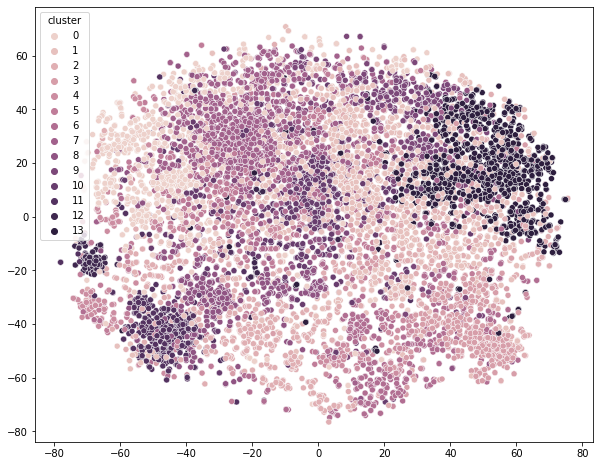

In [ ]:
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(X)
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=netflix_titles['cluster'],legend = 'full')

In [ ]:
netflix_titles_org = pd.read_csv("netflix_titles.csv")
print("Shape of the dataset: ",netflix_titles.shape)
netflix_titles_org['cluster'] = cluster_labels
netflix_titles_org.head()

Shape of the dataset:  (8807, 13)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,cluster
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",1
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,13
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",0
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,5


In [ ]:
random_data = netflix_titles_org[netflix_titles_org['cluster'] == 11].sample(10,random_state = 10)[['title','description']]
for desc,title in zip(random_data['description'],random_data['title']):
  print(title)
  print(desc)
  print('\n')

Pocoyo Carnival
To celebrate the carnival, everyone learns to dance to different music. Plus, Pocoyo's friends surprise him with something delicious.


Astronomy Club: The Sketch Show
With unique individual perspectives that converge into a unified voice, sketch comedy group Astronomy Club delivers a smart and absurd brand of humor.


Colin Quinn: Red State Blue State
Stand-up comedian Colin Quinn calls out the hypocrisies of the left and the right in this special based on his politically charged Off-Broadway show.


Bridgerton - The Afterparty
"Bridgerton" cast members share behind-the-scenes stories from the hit show, plus comedian Nikki Glaser breaks down the costume drama's sexiest moments.


Still LAUGH-IN: The Stars Celebrate
This celebration of the groundbreaking comedy show "Laugh-In" stars Lily Tomlin, Snoop Dogg, Billy Crystal, Tiffany Haddish, Neil Patrick Harris and more.


Sarah Cooper: Everything's Fine
Comedian and Trump lip-synching sensation Sarah Cooper tackles politi

In [ ]:
netflix_titles_org.to_csv("netflix_titles_bert_HC_2.csv")